In [1]:
using FEM, Potential, PyPlot, Printf, JLD, Dierckx

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$

In [29]:
Vref = symmetry_wall_potential.(-64., 64., 2.5, 10.0, xref)
Veq_spl = Spline1D(xref[:,1], Vref[:,1])
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq
s_eq = -sum(w0 .* p_eq .* log.(p_eq))

4.8323621280093

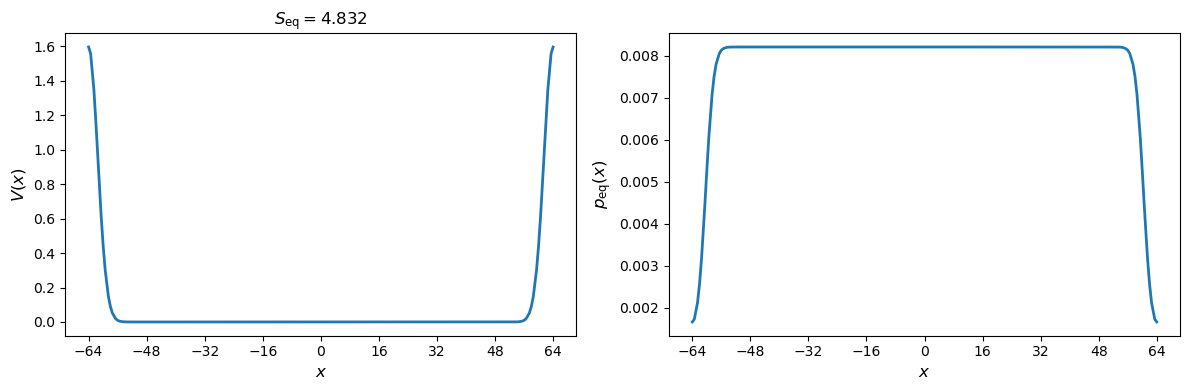

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
#ax.plot(xref, Veq_spl(xref[:,1]))
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)
ax.set_title(@sprintf "\$S_{\\rm eq}=%.3f\$" s_eq)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)


plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/flat_potential_5.svg")
plt.show()

### Part 3: Langenvin dynamics simulations

In [31]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [32]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = -derivative(Veq_spl, ypos)
        ypos = ypos + D*dt*F + (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

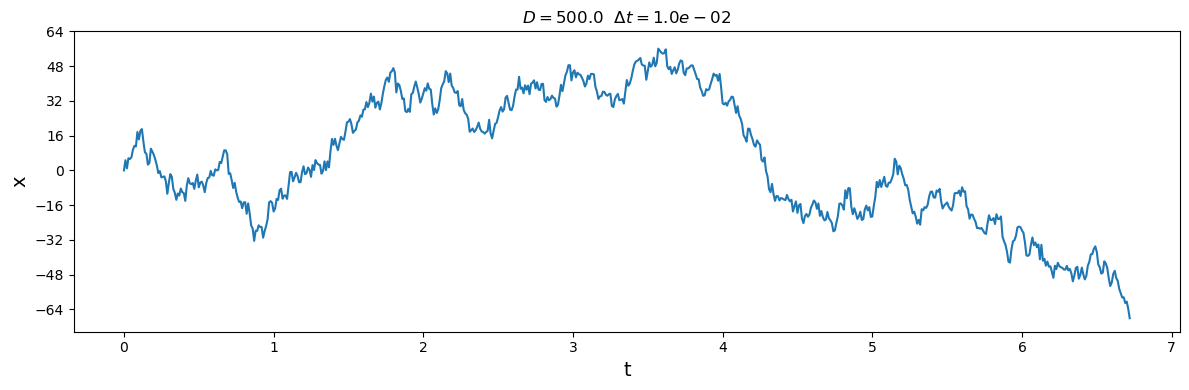

In [33]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x", fontsize=lbfz)
ax.set_xlabel("t", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f~~\\Delta t=%.1e\$" D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 4: Save trajectory or Read trajectory

In [113]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/flat_potential_5.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D)

In [124]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/flat_potential_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
D = load(f_in, "D");

### Part 5: Get eigenvalues and eigenvectors

In [34]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D, Nv);

### Part 6: Get $a_i = \left<\alpha_{t0} | \psi_i \right>$, where $i=1,\cdots,N_v$ and get $p_{appr}$

In [35]:
a_array = FEM.get_coefficients_by_proj(w0, rho_eq, Qx, Nv);

### Part 7: $\rho_{appr}(x) = a_1 \psi_1(x)+ a_2 \psi_2(x)+\cdots+ a_n \psi_n(x) $

In [36]:
rho0_appr = zeros(N)
for idx_eigv in 1:Nv
    rho0_appr = rho0_appr .+ (a_array[idx_eigv] .* Qx[:, idx_eigv])
end

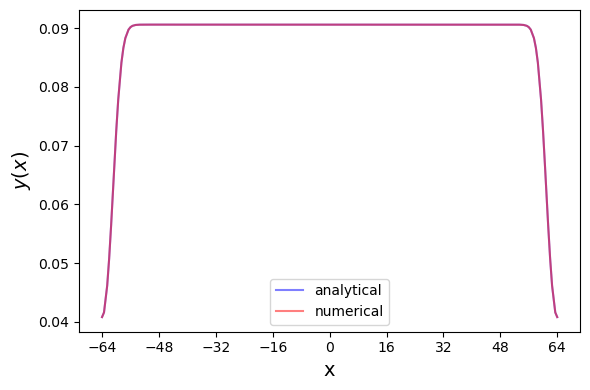

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(xref, rho_eq, color="blue", alpha=0.5, label="analytical")
ax.plot(xref, rho0_appr, color="red", alpha=0.5, label="numerical")
ax.legend()
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("\$ y(x) \$", fontsize=14)
ax.set_xticks(-64:16:64)
#title = @sprintf "\$\\sigma=%1.1f\$" sigma_dirac
#ax.set_title(title)

plt.tight_layout()
plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/sigma_5.svg")
plt.show()